# 目標：利用openpose和神經網路辨識T-POSE和DAB姿勢。

# 組員：
# 應數一 108701011 游能澤
# 應數一 108701034 柯里橫
# 應數一 108701018 池欣霓
# 應數一 108701019 許辰宇

# 分工：
# 構想與建設環境：游能澤、柯里橫
# 程式建構：柯里橫

# 由於一直無法使用pyopenpose函式，無法透過
# openpose取得樣本，只好找別人做好的。

# 到https://github.com/burningion/dab-and-tpose-controlled-lights/tree/master/data
# 載下作者生成好的數據，開個data資料夾放進去
# dabs.npy tposes.npy other.npy
# more-dabs.npy more-tposes.npy more-other.npy
# test-dabs.npy

In [1]:
import numpy as np

# 這幾個檔案是以numpy儲存的二進制文件
# 裡頭有我們需要的特徵

In [2]:
dabDataset = np.load('data/dabs.npy')
tposeDataset = np.load('data/tposes.npy')
otherDataset = np.load('data/other.npy')

In [3]:
dabDataset[0]

array([[5.8832416e+02, 2.9433704e+02, 7.2265184e-01],
       [5.8239331e+02, 3.5126093e+02, 8.0205584e-01],
       [5.0984329e+02, 3.4919385e+02, 7.5316119e-01],
       [4.1784265e+02, 3.1985785e+02, 8.1164622e-01],
       [3.6101605e+02, 2.9243521e+02, 8.0296052e-01],
       [6.5091376e+02, 3.6097537e+02, 6.4161348e-01],
       [6.3724268e+02, 2.7274924e+02, 7.8188539e-01],
       [4.9614203e+02, 2.4154723e+02, 8.3243752e-01],
       [5.4315808e+02, 6.4114813e+02, 4.4807938e-01],
       [4.8636816e+02, 6.2938318e+02, 3.6906898e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [6.0191382e+02, 6.4702966e+02, 3.8946095e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [5.7648334e+02, 2.7475522e+02, 6.1822432e-01],
       [6.0389270e+02, 2.8454663e+02, 4.1854110e-01],
       [5.5686536e+02, 2.6891223e+02, 2.7014270e-01],
       [6.1959991e+02, 2.924

In [4]:
dabDataset.shape

(14, 25, 3)

In [5]:
dabDataset[0].shape

(25, 3)

# Adding our Labels
# Our labels come from the [BODY_25 Pose Output format](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#pose-output-format-body_25) available at the repo.

In [6]:
labels = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow",
 "LWrist", "MidHip", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle",
 "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe", "LHeel", "RBigToe",
 "RSmallToe", "RHeel", "Background"]

## 看數據有三個維度分別是X、Ｙ、Confidence，不需要用到Confidence。

In [7]:
properLabels = []
for label in labels:
    properLabels.append(label + 'X')
    properLabels.append(label + 'Y')
    properLabels.append(label + 'Confidence')

In [8]:
import csv

with open('data/dabs.csv', 'w+') as dabcsv:
    dabwriter = csv.writer(dabcsv, delimiter=',')
    dabwriter.writerow(properLabels)
    for cell in dabDataset:
        dabwriter.writerow(cell.flatten())
        
with open('data/tposes.csv', 'w+') as tposecsv:
    tposewriter = csv.writer(tposecsv, delimiter=',')
    tposewriter.writerow(properLabels)
    for cell in tposeDataset:
        tposewriter.writerow(cell.flatten())
        
with open('data/other.csv', 'w+') as othercsv:
    otherwriter = csv.writer(othercsv, delimiter=',')
    otherwriter.writerow(properLabels)
    for cell in otherDataset:
        otherwriter.writerow(cell.flatten())

# 用CSV檔看訓練資料略少，但還是試著訓練看看。

# Creating a Labeled Dataset for Training and Testing
# We'll use 0 for other poses, 1 for dabs, and 2 for tposes.

In [9]:
labels = np.zeros(len(otherDataset))
labels = np.append(labels, np.full((len(dabDataset)), 1))
labels = np.append(labels, np.full((len(tposeDataset)), 2))
print(labels)
print("%i total examples for training." % len(labels))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2.]
56 total examples for training.


In [10]:
dataset = np.append(otherDataset, dabDataset, axis=0)
dataset = np.append(dataset, tposeDataset, axis=0)
print(dataset)

[[[488.3213     147.51425      0.83340967]
  [494.22372    284.5734       0.8012297 ]
  [386.4863     270.83716      0.66853976]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[515.7737     112.18818      0.83487195]
  [478.48004    274.7029       0.8005627 ]
  [368.77948    257.2105       0.6782713 ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[547.1316     112.15151      0.79948723]
  [464.79065    268.88403      0.73338044]
  [360.98135    243.43745      0.62600124]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 ...

 [[509.97504    257.06958      0.892523  ]
  [460.9663     351.17117      0.7867987 ]
  [372.75305    333.54434      0.6111988 ]
  ...
  [  0.           0.           0.        ]
  [  0.           

In [11]:
dataset.shape

(56, 25, 3)

## 讓數值變成0~1之間

In [12]:
dataset[:,:,1] / 1280

array([[0.11524551, 0.22232297, 0.21159153, ..., 0.        , 0.        ,
        0.        ],
       [0.08764701, 0.21461165, 0.2009457 , ..., 0.        , 0.        ,
        0.        ],
       [0.08761837, 0.21006565, 0.19018552, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.20083562, 0.2743525 , 0.26058152, ..., 0.        , 0.        ,
        0.        ],
       [0.2238348 , 0.29272196, 0.27588812, ..., 0.        , 0.        ,
        0.        ],
       [0.2100658 , 0.28972745, 0.2758514 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

# Shuffle labels and features

In [13]:
from sklearn.utils import shuffle
X, y = shuffle(dataset, labels)
from keras.utils.np_utils import to_categorical
y = to_categorical(y, 3)
print(y.shape[1])

Using TensorFlow backend.


3


# 架設神經網路

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD

In [15]:
X = X.reshape(len(X), 75)
dataset[0]

array([[4.88321289e+02, 1.47514252e+02, 8.33409667e-01],
       [4.94223724e+02, 2.84573395e+02, 8.01229715e-01],
       [3.86486298e+02, 2.70837158e+02, 6.68539762e-01],
       [3.37498718e+02, 4.31440033e+02, 8.06459844e-01],
       [2.76727325e+02, 5.92155334e+02, 6.95721209e-01],
       [6.01926575e+02, 2.96297577e+02, 6.77372575e-01],
       [6.17621460e+02, 4.47154175e+02, 8.15527081e-01],
       [6.33207092e+02, 6.13721497e+02, 7.50288665e-01],
       [4.49166534e+02, 6.23515259e+02, 3.33123893e-01],
       [3.68768433e+02, 6.15664124e+02, 2.96909660e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.29464417e+02, 6.35266663e+02, 3.00662249e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.72626495e+02, 1.25848732e+02, 7.93599010e-01],
       [5.09897217e+02, 1.25915306e+02, 8.75047982e-01],
       [4.47158661e+02, 1.31820

In [16]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (75,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation = 'softmax'))
model.compile(optimizer = SGD(lr = 0.005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(X, y, epochs = 200, batch_size = 64)

Epoch 1/200
56/56 [==============================] - 1s 12ms/step - loss: 255.9729 - accuracy: 0.2679
Epoch 2/200
56/56 [==============================] - 0s 105us/step - loss: 2857.6001 - accuracy: 0.2679
Epoch 3/200
56/56 [==============================] - 0s 108us/step - loss: 25834.7285 - accuracy: 0.2679
Epoch 4/200
56/56 [==============================] - 0s 98us/step - loss: 13238.0859 - accuracy: 0.4643
Epoch 5/200
56/56 [==============================] - 0s 114us/step - loss: 1.0981 - accuracy: 0.3750
Epoch 6/200
56/56 [==============================] - 0s 109us/step - loss: 14.2869 - accuracy: 0.4464
Epoch 7/200
56/56 [==============================] - 0s 102us/step - loss: 1.0957 - accuracy: 0.4107
Epoch 8/200
56/56 [==============================] - 0s 95us/step - loss: 1.0938 - accuracy: 0.4107
Epoch 9/200
56/56 [==============================] - 0s 99us/step - loss: 1.0922 - accuracy: 0.4107
Epoch 10/200
56/56 [==============================] - 0s 115us/step - loss: 1.093

Epoch 82/200
56/56 [==============================] - 0s 101us/step - loss: 1.0571 - accuracy: 0.4643
Epoch 83/200
56/56 [==============================] - 0s 108us/step - loss: 1.1010 - accuracy: 0.4643
Epoch 84/200
56/56 [==============================] - 0s 113us/step - loss: 1.0722 - accuracy: 0.4643
Epoch 85/200
56/56 [==============================] - 0s 118us/step - loss: 1.0837 - accuracy: 0.4643
Epoch 86/200
56/56 [==============================] - 0s 107us/step - loss: 1.0637 - accuracy: 0.4643
Epoch 87/200
56/56 [==============================] - 0s 110us/step - loss: 1.0577 - accuracy: 0.4643
Epoch 88/200
56/56 [==============================] - 0s 127us/step - loss: 1.0952 - accuracy: 0.4643
Epoch 89/200
56/56 [==============================] - 0s 124us/step - loss: 1.0825 - accuracy: 0.4643
Epoch 90/200
56/56 [==============================] - 0s 135us/step - loss: 1.0684 - accuracy: 0.4643
Epoch 91/200
56/56 [==============================] - 0s 126us/step - loss: 1.0905

Epoch 162/200
56/56 [==============================] - 0s 97us/step - loss: 1.0634 - accuracy: 0.4643
Epoch 163/200
56/56 [==============================] - 0s 106us/step - loss: 1.0649 - accuracy: 0.4643
Epoch 164/200
56/56 [==============================] - 0s 102us/step - loss: 1.0903 - accuracy: 0.4643
Epoch 165/200
56/56 [==============================] - 0s 98us/step - loss: 1.1139 - accuracy: 0.4643
Epoch 166/200
56/56 [==============================] - 0s 109us/step - loss: 1.0757 - accuracy: 0.4643
Epoch 167/200
56/56 [==============================] - 0s 103us/step - loss: 1.0862 - accuracy: 0.4643
Epoch 168/200
56/56 [==============================] - 0s 140us/step - loss: 1.0654 - accuracy: 0.4643
Epoch 169/200
56/56 [==============================] - 0s 113us/step - loss: 1.0687 - accuracy: 0.4643
Epoch 170/200
56/56 [==============================] - 0s 113us/step - loss: 1.0751 - accuracy: 0.4643
Epoch 171/200
56/56 [==============================] - 0s 102us/step - loss

# Cleaning up data further¶

## accuracy too low

In [17]:
X, y = shuffle(dataset, labels)
y = to_categorical(y, 3)
print(X.shape)
X[:,:,0] = X[:,:,0] / 720 
X[:,:,1] = X[:,:,1] / 1280
X = X[:,:,:2]
print(X.shape)
X = X.reshape(56, 50)     
print(X.shape)

(56, 25, 3)
(56, 25, 2)
(56, 50)


In [18]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(50,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X, y, epochs=200,batch_size=64)

Epoch 1/200
56/56 [==============================] - 1s 20ms/step - loss: 1.2190 - accuracy: 0.2679
Epoch 2/200
56/56 [==============================] - 0s 108us/step - loss: 1.1808 - accuracy: 0.3571
Epoch 3/200
56/56 [==============================] - 0s 108us/step - loss: 1.1225 - accuracy: 0.3571
Epoch 4/200
56/56 [==============================] - 0s 119us/step - loss: 1.1092 - accuracy: 0.4107
Epoch 5/200
56/56 [==============================] - 0s 111us/step - loss: 1.0194 - accuracy: 0.4464
Epoch 6/200
56/56 [==============================] - 0s 116us/step - loss: 1.0504 - accuracy: 0.4286
Epoch 7/200
56/56 [==============================] - 0s 130us/step - loss: 1.0893 - accuracy: 0.3750
Epoch 8/200
56/56 [==============================] - 0s 124us/step - loss: 1.0746 - accuracy: 0.3929
Epoch 9/200
56/56 [==============================] - 0s 118us/step - loss: 1.0616 - accuracy: 0.5000
Epoch 10/200
56/56 [==============================] - 0s 129us/step - loss: 1.1203 - accurac

Epoch 82/200
56/56 [==============================] - 0s 112us/step - loss: 0.7739 - accuracy: 0.6964
Epoch 83/200
56/56 [==============================] - 0s 110us/step - loss: 0.7656 - accuracy: 0.7679
Epoch 84/200
56/56 [==============================] - 0s 111us/step - loss: 0.7972 - accuracy: 0.6250
Epoch 85/200
56/56 [==============================] - 0s 109us/step - loss: 0.7784 - accuracy: 0.6607
Epoch 86/200
56/56 [==============================] - 0s 115us/step - loss: 0.7673 - accuracy: 0.7143
Epoch 87/200
56/56 [==============================] - 0s 118us/step - loss: 0.7466 - accuracy: 0.7679
Epoch 88/200
56/56 [==============================] - 0s 118us/step - loss: 0.7406 - accuracy: 0.6786
Epoch 89/200
56/56 [==============================] - 0s 110us/step - loss: 0.7457 - accuracy: 0.7321
Epoch 90/200
56/56 [==============================] - 0s 121us/step - loss: 0.7410 - accuracy: 0.6429
Epoch 91/200
56/56 [==============================] - 0s 111us/step - loss: 0.7590

Epoch 162/200
56/56 [==============================] - 0s 124us/step - loss: 0.3762 - accuracy: 0.8571
Epoch 163/200
56/56 [==============================] - 0s 108us/step - loss: 0.3944 - accuracy: 0.8571
Epoch 164/200
56/56 [==============================] - 0s 112us/step - loss: 0.3970 - accuracy: 0.8393
Epoch 165/200
56/56 [==============================] - 0s 111us/step - loss: 0.4052 - accuracy: 0.8214
Epoch 166/200
56/56 [==============================] - 0s 110us/step - loss: 0.3657 - accuracy: 0.8393
Epoch 167/200
56/56 [==============================] - 0s 108us/step - loss: 0.3638 - accuracy: 0.8393
Epoch 168/200
56/56 [==============================] - 0s 104us/step - loss: 0.3729 - accuracy: 0.8214
Epoch 169/200
56/56 [==============================] - 0s 111us/step - loss: 0.3762 - accuracy: 0.8036
Epoch 170/200
56/56 [==============================] - 0s 107us/step - loss: 0.3813 - accuracy: 0.8036
Epoch 171/200
56/56 [==============================] - 0s 107us/step - lo

# Adding More Data and Beginning Data Augmentation

In [19]:
dabDataset = np.load('data/more-dabs.npy')
tposeDataset = np.load('data/more-tposes.npy')
otherDataset = np.load('data/more-other.npy')
labels1 = np.zeros(len(otherDataset))
labels1 = np.append(labels1, np.full((len(dabDataset)), 1))
labels1 = np.append(labels1, np.full((len(tposeDataset)), 2))
print(labels1)
print("%i total new samples" % len(labels1))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.]
171 total new samples


In [20]:
dataset1 = np.append(otherDataset, dabDataset, axis=0)
dataset1 = np.append(dataset1, tposeDataset, axis=0)
X1, y1 = shuffle(dataset1, labels1)
y1 = to_categorical(y1, 3)
print(X1.shape)
X1[:,:,0] = X1[:,:,0] / 720
X1[:,:,1] = X1[:,:,1] / 1280
X1 = X1[:,:,:2]
print(X1.shape)
X1 = X1.reshape(len(X1), 50)    
print(X1.shape)

(171, 25, 3)
(171, 25, 2)
(171, 50)


In [30]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (50,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation = 'softmax'))
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(X1, y1, validation_split=0.33, epochs = 1000,batch_size = 64)

Train on 114 samples, validate on 57 samples
Epoch 1/1000
114/114 [==============================] - 1s 9ms/step - loss: 1.3154 - accuracy: 0.3158 - val_loss: 1.1753 - val_accuracy: 0.2807
Epoch 2/1000
114/114 [==============================] - 0s 132us/step - loss: 1.2615 - accuracy: 0.3246 - val_loss: 1.1142 - val_accuracy: 0.4561
Epoch 3/1000
114/114 [==============================] - 0s 140us/step - loss: 1.1290 - accuracy: 0.3860 - val_loss: 1.0927 - val_accuracy: 0.3684
Epoch 4/1000
114/114 [==============================] - 0s 145us/step - loss: 1.0584 - accuracy: 0.4561 - val_loss: 1.0895 - val_accuracy: 0.3684
Epoch 5/1000
114/114 [==============================] - 0s 167us/step - loss: 1.0801 - accuracy: 0.4211 - val_loss: 1.0848 - val_accuracy: 0.3684
Epoch 6/1000
114/114 [==============================] - 0s 156us/step - loss: 1.0314 - accuracy: 0.4912 - val_loss: 1.0770 - val_accuracy: 0.3684
Epoch 7/1000
114/114 [==============================] - 0s 147us/step - loss: 1.0

114/114 [==============================] - 0s 152us/step - loss: 0.5631 - accuracy: 0.7281 - val_loss: 0.6191 - val_accuracy: 0.7193
Epoch 57/1000
114/114 [==============================] - 0s 167us/step - loss: 0.5229 - accuracy: 0.8158 - val_loss: 0.6049 - val_accuracy: 0.7193
Epoch 58/1000
114/114 [==============================] - 0s 143us/step - loss: 0.5529 - accuracy: 0.8158 - val_loss: 0.5843 - val_accuracy: 0.7368
Epoch 59/1000
114/114 [==============================] - 0s 144us/step - loss: 0.4700 - accuracy: 0.8070 - val_loss: 0.5670 - val_accuracy: 0.7193
Epoch 60/1000
114/114 [==============================] - 0s 148us/step - loss: 0.4736 - accuracy: 0.8158 - val_loss: 0.5535 - val_accuracy: 0.7719
Epoch 61/1000
114/114 [==============================] - 0s 149us/step - loss: 0.5041 - accuracy: 0.8333 - val_loss: 0.5395 - val_accuracy: 0.7368
Epoch 62/1000
114/114 [==============================] - 0s 168us/step - loss: 0.4782 - accuracy: 0.8246 - val_loss: 0.5375 - val_ac

Epoch 112/1000
114/114 [==============================] - 0s 138us/step - loss: 0.2360 - accuracy: 0.9386 - val_loss: 0.2685 - val_accuracy: 0.8421
Epoch 113/1000
114/114 [==============================] - 0s 139us/step - loss: 0.1690 - accuracy: 0.9649 - val_loss: 0.2785 - val_accuracy: 0.8421
Epoch 114/1000
114/114 [==============================] - 0s 135us/step - loss: 0.1521 - accuracy: 0.9649 - val_loss: 0.2721 - val_accuracy: 0.8421
Epoch 115/1000
114/114 [==============================] - 0s 133us/step - loss: 0.1537 - accuracy: 0.9649 - val_loss: 0.2612 - val_accuracy: 0.8421
Epoch 116/1000
114/114 [==============================] - 0s 131us/step - loss: 0.1568 - accuracy: 0.9561 - val_loss: 0.2566 - val_accuracy: 0.8596
Epoch 117/1000
114/114 [==============================] - 0s 128us/step - loss: 0.1573 - accuracy: 0.9561 - val_loss: 0.2558 - val_accuracy: 0.8596
Epoch 118/1000
114/114 [==============================] - 0s 129us/step - loss: 0.1702 - accuracy: 0.9649 - val_

114/114 [==============================] - 0s 147us/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9123
Epoch 168/1000
114/114 [==============================] - 0s 148us/step - loss: 0.1025 - accuracy: 0.9649 - val_loss: 0.1568 - val_accuracy: 0.8947
Epoch 169/1000
114/114 [==============================] - 0s 135us/step - loss: 0.0703 - accuracy: 0.9912 - val_loss: 0.1514 - val_accuracy: 0.9123
Epoch 170/1000
114/114 [==============================] - 0s 137us/step - loss: 0.0802 - accuracy: 0.9737 - val_loss: 0.1506 - val_accuracy: 0.9123
Epoch 171/1000
114/114 [==============================] - 0s 127us/step - loss: 0.1056 - accuracy: 0.9649 - val_loss: 0.1500 - val_accuracy: 0.9123
Epoch 172/1000
114/114 [==============================] - 0s 131us/step - loss: 0.1068 - accuracy: 0.9649 - val_loss: 0.1512 - val_accuracy: 0.9123
Epoch 173/1000
114/114 [==============================] - 0s 132us/step - loss: 0.1038 - accuracy: 0.9737 - val_loss: 0.1651 - 

114/114 [==============================] - 0s 133us/step - loss: 0.1072 - accuracy: 0.9474 - val_loss: 0.1052 - val_accuracy: 0.9474
Epoch 223/1000
114/114 [==============================] - 0s 133us/step - loss: 0.0462 - accuracy: 0.9825 - val_loss: 0.1116 - val_accuracy: 0.9474
Epoch 224/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0452 - accuracy: 1.0000 - val_loss: 0.1278 - val_accuracy: 0.9298
Epoch 225/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0544 - accuracy: 0.9912 - val_loss: 0.1326 - val_accuracy: 0.9298
Epoch 226/1000
114/114 [==============================] - 0s 130us/step - loss: 0.0606 - accuracy: 0.9825 - val_loss: 0.1320 - val_accuracy: 0.9298
Epoch 227/1000
114/114 [==============================] - 0s 131us/step - loss: 0.0603 - accuracy: 0.9825 - val_loss: 0.1380 - val_accuracy: 0.9298
Epoch 228/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0433 - accuracy: 1.0000 - val_loss: 0.1420 - 

114/114 [==============================] - 0s 131us/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.0917 - val_accuracy: 0.9474
Epoch 278/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.9298
Epoch 279/1000
114/114 [==============================] - 0s 126us/step - loss: 0.0407 - accuracy: 0.9912 - val_loss: 0.0922 - val_accuracy: 0.9298
Epoch 280/1000
114/114 [==============================] - 0s 130us/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.0992 - val_accuracy: 0.9474
Epoch 281/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.1002 - val_accuracy: 0.9474
Epoch 282/1000
114/114 [==============================] - 0s 130us/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.9474
Epoch 283/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0404 - accuracy: 0.9825 - val_loss: 0.1080 - 

114/114 [==============================] - 0s 135us/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9649
Epoch 333/1000
114/114 [==============================] - 0s 144us/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9649
Epoch 334/1000
114/114 [==============================] - 0s 146us/step - loss: 0.0182 - accuracy: 0.9912 - val_loss: 0.0885 - val_accuracy: 0.9649
Epoch 335/1000
114/114 [==============================] - 0s 155us/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9649
Epoch 336/1000
114/114 [==============================] - 0s 173us/step - loss: 0.0188 - accuracy: 0.9912 - val_loss: 0.1084 - val_accuracy: 0.9474
Epoch 337/1000
114/114 [==============================] - 0s 164us/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.1140 - val_accuracy: 0.9474
Epoch 338/1000
114/114 [==============================] - 0s 171us/step - loss: 0.0298 - accuracy: 0.9912 - val_loss: 0.1093 - 

114/114 [==============================] - 0s 135us/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 0.9649
Epoch 388/1000
114/114 [==============================] - 0s 133us/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.1032 - val_accuracy: 0.9649
Epoch 389/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0969 - val_accuracy: 0.9649
Epoch 390/1000
114/114 [==============================] - 0s 136us/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.0939 - val_accuracy: 0.9649
Epoch 391/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0918 - val_accuracy: 0.9649
Epoch 392/1000
114/114 [==============================] - 0s 143us/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 0.9649
Epoch 393/1000
114/114 [==============================] - 0s 141us/step - loss: 0.0433 - accuracy: 0.9825 - val_loss: 0.1005 - 

114/114 [==============================] - 0s 134us/step - loss: 0.0224 - accuracy: 0.9912 - val_loss: 0.0966 - val_accuracy: 0.9649
Epoch 443/1000
114/114 [==============================] - 0s 133us/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0947 - val_accuracy: 0.9649
Epoch 444/1000
114/114 [==============================] - 0s 130us/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0917 - val_accuracy: 0.9649
Epoch 445/1000
114/114 [==============================] - 0s 135us/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9649
Epoch 446/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 0.9649
Epoch 447/1000
114/114 [==============================] - 0s 131us/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.9649
Epoch 448/1000
114/114 [==============================] - 0s 133us/step - loss: 0.0217 - accuracy: 0.9825 - val_loss: 0.0769 - 

114/114 [==============================] - 0s 130us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9649
Epoch 498/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9649
Epoch 499/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0798 - val_accuracy: 0.9649
Epoch 500/1000
114/114 [==============================] - 0s 125us/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9649
Epoch 501/1000
114/114 [==============================] - 0s 130us/step - loss: 0.0176 - accuracy: 0.9912 - val_loss: 0.0823 - val_accuracy: 0.9649
Epoch 502/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0359 - accuracy: 0.9825 - val_loss: 0.1177 - val_accuracy: 0.9474
Epoch 503/1000
114/114 [==============================] - 0s 126us/step - loss: 0.0239 - accuracy: 0.9912 - val_loss: 0.1403 - 

114/114 [==============================] - 0s 133us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9474
Epoch 553/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0741 - val_accuracy: 0.9474
Epoch 554/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0724 - val_accuracy: 0.9474
Epoch 555/1000
114/114 [==============================] - 0s 126us/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.9649
Epoch 556/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0954 - val_accuracy: 0.9649
Epoch 557/1000
114/114 [==============================] - 0s 125us/step - loss: 0.0105 - accuracy: 0.9912 - val_loss: 0.0908 - val_accuracy: 0.9649
Epoch 558/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0952 - 

114/114 [==============================] - 0s 145us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.9649
Epoch 608/1000
114/114 [==============================] - 0s 146us/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9649
Epoch 609/1000
114/114 [==============================] - 0s 141us/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.0810 - val_accuracy: 0.9649
Epoch 610/1000
114/114 [==============================] - 0s 142us/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0952 - val_accuracy: 0.9649
Epoch 611/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0106 - accuracy: 0.9912 - val_loss: 0.0993 - val_accuracy: 0.9649
Epoch 612/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0989 - val_accuracy: 0.9649
Epoch 613/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0994 - 

114/114 [==============================] - 0s 129us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0563 - val_accuracy: 0.9649
Epoch 663/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0160 - accuracy: 0.9912 - val_loss: 0.0667 - val_accuracy: 0.9649
Epoch 664/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9649
Epoch 665/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0934 - val_accuracy: 0.9649
Epoch 666/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.1204 - val_accuracy: 0.9474
Epoch 667/1000
114/114 [==============================] - 0s 129us/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1455 - val_accuracy: 0.9298
Epoch 668/1000
114/114 [==============================] - 0s 128us/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1415 - 

114/114 [==============================] - 0s 153us/step - loss: 0.0342 - accuracy: 0.9912 - val_loss: 0.0836 - val_accuracy: 0.9649
Epoch 718/1000
114/114 [==============================] - 0s 151us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9474
Epoch 719/1000
114/114 [==============================] - 0s 134us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9474
Epoch 720/1000
114/114 [==============================] - 0s 141us/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0992 - val_accuracy: 0.9474
Epoch 721/1000
114/114 [==============================] - 0s 147us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0981 - val_accuracy: 0.9474
Epoch 722/1000
114/114 [==============================] - 0s 143us/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9474
Epoch 723/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0149 - accuracy: 0.9912 - val_loss: 0.0876 - 

114/114 [==============================] - 0s 132us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9649
Epoch 773/1000
114/114 [==============================] - 0s 127us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9649
Epoch 774/1000
114/114 [==============================] - 0s 138us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9649
Epoch 775/1000
114/114 [==============================] - 0s 134us/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9649
Epoch 776/1000
114/114 [==============================] - 0s 150us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0793 - val_accuracy: 0.9649
Epoch 777/1000
114/114 [==============================] - 0s 138us/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0835 - val_accuracy: 0.9649
Epoch 778/1000
114/114 [==============================] - 0s 139us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0869 - 

114/114 [==============================] - 0s 138us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9649
Epoch 828/1000
114/114 [==============================] - 0s 141us/step - loss: 0.0145 - accuracy: 0.9912 - val_loss: 0.0760 - val_accuracy: 0.9649
Epoch 829/1000
114/114 [==============================] - 0s 136us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0817 - val_accuracy: 0.9649
Epoch 830/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9649
Epoch 831/1000
114/114 [==============================] - 0s 136us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.9649
Epoch 832/1000
114/114 [==============================] - 0s 132us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9649
Epoch 833/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0225 - accuracy: 0.9912 - val_loss: 0.0863 - 

114/114 [==============================] - 0s 136us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9649
Epoch 883/1000
114/114 [==============================] - 0s 142us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9649
Epoch 884/1000
114/114 [==============================] - 0s 139us/step - loss: 0.0234 - accuracy: 0.9912 - val_loss: 0.0904 - val_accuracy: 0.9649
Epoch 885/1000
114/114 [==============================] - 0s 138us/step - loss: 0.0091 - accuracy: 0.9912 - val_loss: 0.0718 - val_accuracy: 0.9649
Epoch 886/1000
114/114 [==============================] - 0s 135us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9649
Epoch 887/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9649
Epoch 888/1000
114/114 [==============================] - 0s 137us/step - loss: 0.0163 - accuracy: 0.9912 - val_loss: 0.0576 - 

114/114 [==============================] - 0s 148us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0810 - val_accuracy: 0.9649
Epoch 938/1000
114/114 [==============================] - 0s 145us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.9649
Epoch 939/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.9649
Epoch 940/1000
114/114 [==============================] - 0s 139us/step - loss: 9.1356e-04 - accuracy: 1.0000 - val_loss: 0.0731 - val_accuracy: 0.9649
Epoch 941/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0711 - val_accuracy: 0.9649
Epoch 942/1000
114/114 [==============================] - 0s 143us/step - loss: 0.0122 - accuracy: 0.9912 - val_loss: 0.0762 - val_accuracy: 0.9649
Epoch 943/1000
114/114 [==============================] - 0s 143us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.092

114/114 [==============================] - 0s 143us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 0.9474
Epoch 993/1000
114/114 [==============================] - 0s 138us/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 0.9474
Epoch 994/1000
114/114 [==============================] - 0s 139us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1157 - val_accuracy: 0.9474
Epoch 995/1000
114/114 [==============================] - 0s 138us/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1101 - val_accuracy: 0.9474
Epoch 996/1000
114/114 [==============================] - 0s 140us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1057 - val_accuracy: 0.9649
Epoch 997/1000
114/114 [==============================] - 0s 143us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9649
Epoch 998/1000
114/114 [==============================] - 0s 148us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0952 - 

In [31]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


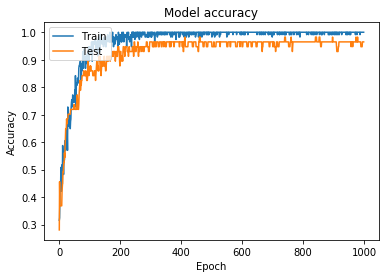

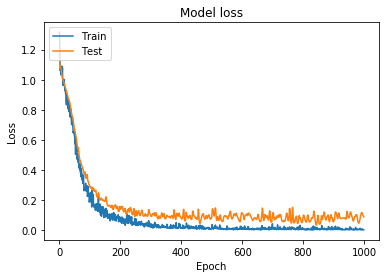

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
model.predict_classes(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [35]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1

In [36]:
model.test_on_batch(X, y)

[8.783125, 0.7256637]

In [37]:
model.save('data/dab-tpose-other.h5')

In [38]:
import keras
modello = keras.models.load_model('data/dab-tpose-other.h5')

In [39]:
dabDataset = np.load('data/test-dabs.npy')
dabDataset[:,:,0] = dabDataset[:,:,0] / 720
dabDataset[:,:,1] = dabDataset[:,:,1] / 1280
dabDataset = dabDataset[:,:,:2]
dabDataset = dabDataset.reshape(len(dabDataset), 50)
modello.predict_classes(dabDataset)

array([1, 1, 1, 0, 1, 1])

# 模型是做好了，但卻無法使用，由於導入pyopenpose的不成功，無法在python裡呼叫openpose來作業，沒辦法實際應用。